## Introducing Heavy Tails

(5000, 3)


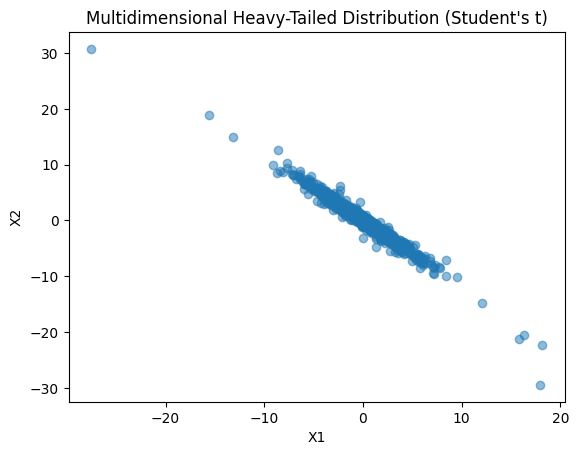

In [70]:
import numpy as np

def generate_heavy_tailed_distribution(n_samples=1000, df=3, dim=3, seed=219):
    np.random.seed(seed)

    # Mean vector (center of distribution)
    mean = np.zeros(dim)

    # Covariance matrix (random positive-definite matrix)
    A = np.random.randn(dim, dim)
    cov_matrix = np.dot(A, A.T)  # Ensures it's positive semi-definite

    # Generate multivariate normal samples
    normal_samples = np.random.multivariate_normal(mean, cov_matrix, size=n_samples)

    # Generate chi-squared distributed samples
    chi_samples = np.random.chisquare(df, size=(n_samples, 1))

    # Compute heavy-tailed Student’s t-distributed samples
    t_samples = normal_samples / np.sqrt(chi_samples / df)

    return t_samples

# Generate samples
samples = generate_heavy_tailed_distribution(n_samples=5000)

# Display shape
print(samples.shape)

# Optionally, visualize one 2D projection
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Multidimensional Heavy-Tailed Distribution (Student's t)")
plt.show()


For now, basic code is without heavy-tailed noise. Instead I use a normal noise.

## Loading data

In [1]:
import requests
from sklearn.datasets import load_svmlight_file

# URL of the file to download
url = 'https://hse24.fmin.xyz/files/mushrooms.txt'

# Download the file and save it locally
response = requests.get(url)
dataset = 'mushrooms.txt'

# Ensure the request was successful
if response.status_code == 200:
    with open(dataset, 'wb') as f:
        f.write(response.content)

    # Load the dataset from the downloaded file
    data = load_svmlight_file(dataset)
    A, b = data[0].toarray(), data[1]
    n, d = A.shape
    b = (b - 3/2) * 2 # to +-1
    print("Data loaded successfully.")
    print(f"Number of samples: {n}, Number of features: {d}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Data loaded successfully.
Number of samples: 8124, Number of features: 112


In [2]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
# Number of workers
num_workers = 10

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=214)

# Initialize empty lists for workers
X_splits, y_splits = [], []

X_remaining, y_remaining = A_train, b_train
for _ in range(num_workers - 1):  # Last worker gets remaining data
    X_part, X_remaining, y_part, y_remaining = train_test_split(
        X_remaining, y_remaining, train_size=1/(num_workers - len(X_splits)), stratify=y_remaining
    )
    X_splits.append(X_part)
    y_splits.append(y_part)

X_splits.append(X_remaining)  # Last split
y_splits.append(y_remaining)

# Workers' data
workers_data = list(zip(X_splits, y_splits))

workers_data[0][0].shape

(649, 112)

## Experiment

In [3]:
import numpy as np

lambda_reg = 1e-3

m = len(A_train)
singular_values = np.linalg.svd(A_train.T, compute_uv=False)
L = np.max(singular_values)**2 / (4*m) + lambda_reg

mu = lambda_reg

print(f"L = {L:.6f}")
print(f"μ = {mu:.6f}")


L = 2.589089
μ = 0.001000


In [4]:
def compute_objective(mat_A, vec_b, point_w, reg_const):
    log_terms = np.log(1 + np.exp(-vec_b * (mat_A @ point_w)))
    reg_term = (reg_const/2) * np.linalg.norm(point_w)**2
    return np.mean(log_terms) + reg_term

def compute_gradient(mat_A, vec_b, point_w, reg_const, noise=None):
    m = mat_A.shape[0]
    sigmoid_vec = 1 / (1 + np.exp(vec_b * (mat_A @ point_w)))
    noise_add = 0
    if noise == 'normal':
        noise_add = np.random.normal(0, 1, point_w.shape[0])
    return (1/m) * mat_A.T @ (-vec_b * sigmoid_vec) + reg_const * point_w + noise_add

def compute_accuracy(obj_features, obj_classes, weights):
    predictions = np.sign(obj_features @ weights)
    return np.mean(predictions == obj_classes)

In [5]:
def sign_grad(grad):
    return np.sign(grad)

Final training accuracy: 0.9368
Final test accuracy: 0.9403
Final training accuracy: 0.9866
Final test accuracy: 0.9840
Final training accuracy: 0.9545
Final test accuracy: 0.9520
Final training accuracy: 0.9968
Final test accuracy: 0.9975


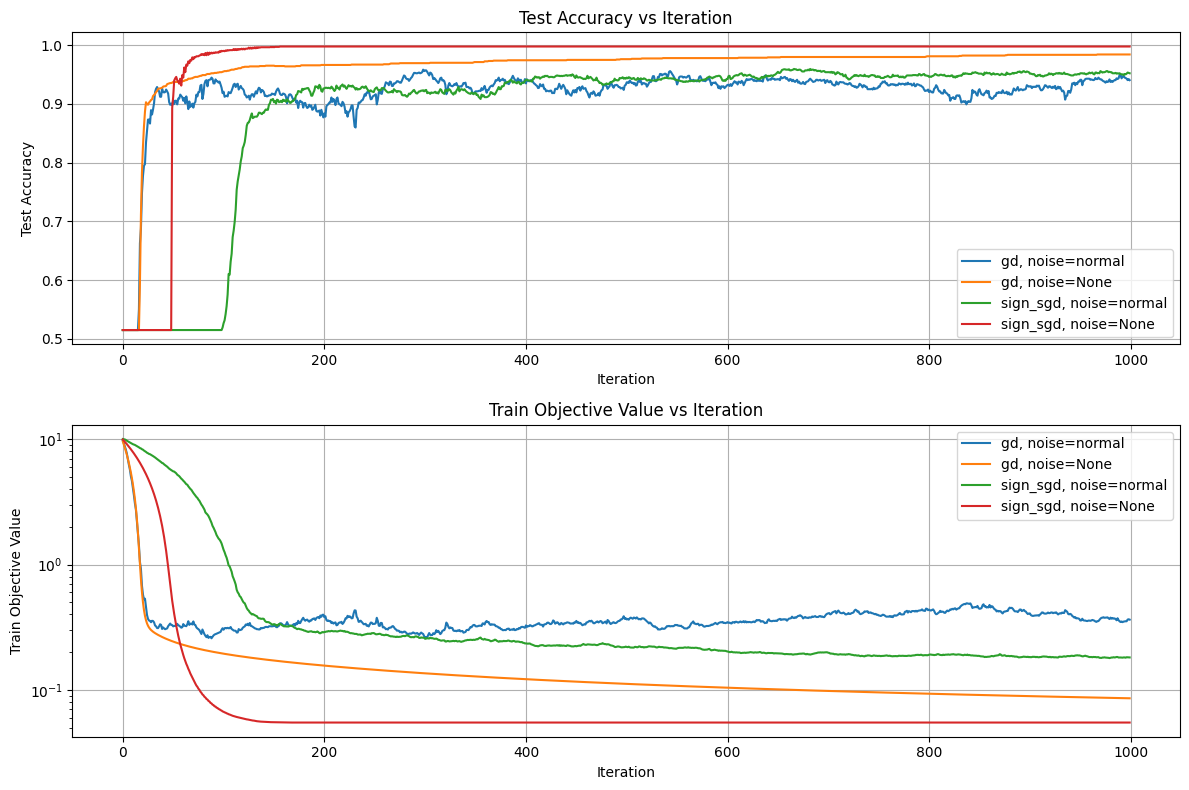

In [6]:
import matplotlib.pyplot as plt

w_start = np.ones(A_train.shape[1])
max_iter = 1000
step_size = 0.02

def gradient_descent(work_data, w_init, alpha, max_iter, alg='gd', noise=None):
    w = w_init.copy()
    gd_accuracies = []
    objective_values = []
    for i in range(max_iter):
        # add the case of basic gradient descent
        sum_grads = 0
        for mat_A, vec_b in work_data:
            grad = compute_gradient(mat_A, vec_b, w, mu, noise)
            if alg=='gd':
                sum_grads += grad
            if alg =='sign_sgd':
                sum_grads += np.sign(grad)
        if alg == 'gd':
            w = w - alpha * sum_grads
        if alg == 'sign_sgd':
            w = w - alpha * sign_grad(sum_grads)
        # Compute and store accuracy
        acc = compute_accuracy(A_test, b_test, w)
        gd_accuracies.append(acc)

        obj_val = compute_objective(A_train, b_train, w, mu)
        objective_values.append(obj_val)

    final_train_acc = compute_accuracy(A_train, b_train, w)
    final_test_acc = compute_accuracy(A_test, b_test, w)
    print(f"Final training accuracy: {final_train_acc:.4f}")
    print(f"Final test accuracy: {final_test_acc:.4f}")
    return objective_values, gd_accuracies

figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
params = [['gd', 'normal'],['gd', None], ['sign_sgd', 'normal'], ['sign_sgd', None]]
for (algos, noise_type) in params:
    objective_values, accuracies = gradient_descent(workers_data, w_start, step_size, max_iter, algos, noise_type)
    
    axes[0].plot(range(max_iter), accuracies, label=f'{algos}, noise={noise_type}')
    axes[1].plot(range(max_iter), objective_values, label=f'{algos}, noise={noise_type}')
    

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy vs Iteration')
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[1].set_yscale('log')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Train Objective Value')
axes[1].set_title('Train Objective Value vs Iteration')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.savefig("../article/sign_sgd_dp.png")
plt.show()